# 03. Model Implementation & Training

This notebook covers the **Model Implementation & Training** phase (Chapter 5.3) of our case study. We aim to learn low-dimensional vector representations (embeddings) for every Output Area (OA) in Liverpool using Graph Auto-Encoders (GAE).

In [ ]:
"""
# Colab setup (optional)
!git clone https://github.com/c2g-dev/city2graph-case-study.git

import os
REPO_DIR = "/content/city2graph-case-study"
os.chdir(REPO_DIR)

# delete data directory
!rm -rf /content/city2graph-case-study/data

# download data zip from Zenodo and unzip into data/
!wget -O /content/city2graph-case-study/data.zip https://zenodo.org/records/18396286/files/data.zip?download=1
!unzip -o /content/city2graph-case-study/data.zip -d /content/city2graph-case-study/

!pip install torch_geometric
!pip install city2graph

os.chdir(REPO_DIR + "/notebooks")
"""

# Colab setup disabled by automated script


In [ ]:
import sys
import os

# Add project root to path to allow imports from src
sys.path.append(os.path.abspath('..'))

import yaml
import random
import torch
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import city2graph as c2g
from src.models import GATGAE, HANGAE

%matplotlib inline

## 1. Configuration & Setup
We load hyperparameters from `../onfigs/experiment_config.yaml`. This ensures reproducibility and easy tuning of parameters like learning rate, hidden dimensions, and structure loss weights.

In [3]:
def load_config(config_path):
    with open(config_path, 'r') as f:
        return yaml.safe_load(f)

config = load_config('../configs/experiment_config.yaml')

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

set_seeds(config['seeds']['global'])
device = torch.device(config['experiment']['device'] if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Ensure output directories exist
os.makedirs("../data/outputs/checkpoints", exist_ok=True)
os.makedirs("../data/outputs/embeddings", exist_ok=True)
os.makedirs("../data/outputs/clusters", exist_ok=True)
os.makedirs("../data/outputs/figures", exist_ok=True)

Random seed set to: 42
Using device: cpu


## 2. Training Utility
This general training loop handles:
1.  **Optimization**: Updating model weights using Adam.
2.  **Loss Calculation**: Combining Feature Reconstruction Loss (Smooth L1) and Structure Reconstruction Loss (DistMult).
3.  **Early Stopping**: Preventing overfitting by monitoring loss improvement.
4.  **Embedding Generation**: Extracting the latent `z` vectors from the best model state.
5.  **Clustering**: Automatically clustering the resulting embeddings.

In [4]:
def train_model(model, data, config, model_name):
    print(f"Training {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=config['training']['lr'])
    best_loss = float('inf')
    patience = config['training']['early_stopping_patience']
    patience_counter = 0
    
    checkpoint_dir = f"../data/outputs/checkpoints/{model_name}"
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    losses = []
    
    for epoch in range(config['training']['epochs']):
        model.train()
        optimizer.zero_grad()
        loss, l_feat, l_struct = model.compute_loss(
            data, 
            lambda_struct=config['model']['lambda_struct'],
            neg_sampling_ratio=config['training']["neg_sampling_ratio"]
        )
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        # Logging
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Total Loss: {loss.item():.4f}, Feat Loss: {l_feat.item():.4f}, Struct Loss: {l_struct.item():.4f}")
            
        # Early Stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), f"{checkpoint_dir}/model.pt")
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
            
    # Load best model for embedding generation
    model.load_state_dict(torch.load(f"{checkpoint_dir}/model.pt"))
    model.eval()
    with torch.no_grad():
        if isinstance(model, GATGAE):
            z, _ = model(data)
            for i in range(z.shape[1]):
                data[f"embedding_{i}"] = z[:, i]

        else: # HANGAE
            z, _, beta1, beta2 = model(data)
            for i in range(z.shape[1]):
                data["oa"][f"embedding_{i}"] = z[:, i]
            for i in range(beta1.shape[1]):
                data["oa"][f"beta1_{i}"] = beta1[:, i]
            for i in range(beta2.shape[1]):
                data["oa"][f"beta2_{i}"] = beta2[:, i]

        torch.save(data, f"../data/outputs/embeddings/{model_name}.pt")
        
    return data, losses

## 3. Workflows

### 3.1. Model 1: GAT-GAE (Homogeneous)
This model learns embeddings by aggregating features from spatially contiguous neighbors. It assumes that functional regions are spatially smooth.

In [5]:
# Load Data
homo_path = os.path.join("../", config['data']['root'], config['data']['homo'])

homo_data = torch.load(homo_path, map_location=device, weights_only=False)

In [6]:
# Ensure deterministic model training initialization
set_seeds(config['seeds']['model'])

# Set device
homo_data = homo_data.to(device)

# Initialize Model 1: GAT-GAE
gat_model = GATGAE(
    in_dim=config['model']['in_dim'],
    hidden_dim=config['model']['hidden_dim'],
    out_dim=config['model']['out_dim'],
    heads=config['model']['heads'],
    dropout=config['model']['dropout'],
).to(device)

# Train Model 1
data_model1, losses_model1 = train_model(gat_model, homo_data, config, "model1_gat_gae")

Random seed set to: 42
Training model1_gat_gae...
Epoch 0, Total Loss: 2.5175, Feat Loss: 0.4179, Struct Loss: 2.0995
Epoch 10, Total Loss: 2.0174, Feat Loss: 0.3847, Struct Loss: 1.6327
Epoch 20, Total Loss: 1.9041, Feat Loss: 0.3641, Struct Loss: 1.5400
Epoch 30, Total Loss: 1.8355, Feat Loss: 0.3533, Struct Loss: 1.4822
Epoch 40, Total Loss: 1.7832, Feat Loss: 0.3406, Struct Loss: 1.4425
Epoch 50, Total Loss: 1.7824, Feat Loss: 0.3403, Struct Loss: 1.4421
Epoch 60, Total Loss: 1.7336, Feat Loss: 0.3324, Struct Loss: 1.4012
Epoch 70, Total Loss: 1.7381, Feat Loss: 0.3291, Struct Loss: 1.4090
Epoch 80, Total Loss: 1.7023, Feat Loss: 0.3289, Struct Loss: 1.3735
Epoch 90, Total Loss: 1.7064, Feat Loss: 0.3242, Struct Loss: 1.3822
Epoch 100, Total Loss: 1.7119, Feat Loss: 0.3231, Struct Loss: 1.3888
Epoch 110, Total Loss: 1.6716, Feat Loss: 0.3204, Struct Loss: 1.3512
Epoch 120, Total Loss: 1.6676, Feat Loss: 0.3184, Struct Loss: 1.3492
Epoch 130, Total Loss: 1.6651, Feat Loss: 0.3153, S

In [7]:
data_model1

Data(x=[1624, 23], edge_index=[2, 4782], edge_attr=[4782, 1], pos=[1624, 2], graph_metadata=<city2graph.base.GraphMetadata object at 0x1334ae660>, embedding_0=[1624], embedding_1=[1624], embedding_2=[1624], embedding_3=[1624], embedding_4=[1624], embedding_5=[1624], embedding_6=[1624], embedding_7=[1624], embedding_8=[1624], embedding_9=[1624], embedding_10=[1624], embedding_11=[1624], embedding_12=[1624], embedding_13=[1624], embedding_14=[1624], embedding_15=[1624])

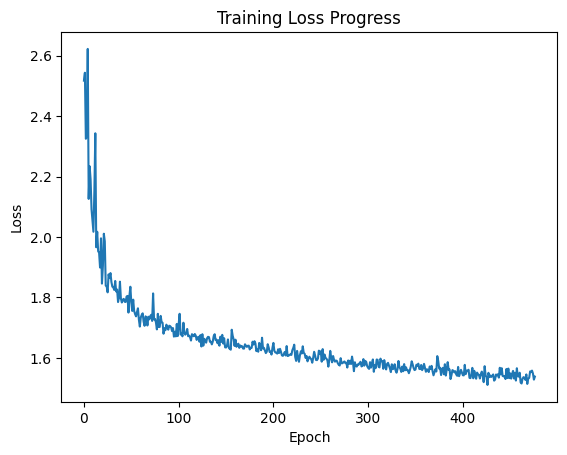

In [8]:
plt.plot(losses_model1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()

### 3.2. Model 2: HAN-GAE (Street)
This model introduces heterogeneity. It learns to aggregate information not just from contiguous OAs, but also from OAs connected via the street network (15-min walk).

In [9]:
# Ensure deterministic model training initialization
set_seeds(config['seeds']['model'])

# Load Heterogeneous Graph
walk_path = os.path.join("../", config['data']['root'], config['data']['hetero_walk'])
walk_data = torch.load(walk_path, map_location=device, weights_only=False)

# Define metapaths for Model 2
metapaths_walk = ['contig', '15_min_walk']

# Initialize Model 2
han_walk = HANGAE(
    in_dim=config['model']['in_dim'],
    hidden_dim=config['model']['hidden_dim'],
    out_dim=config['model']['out_dim'],
    metapaths=metapaths_walk,
    heads=config['model']['heads'],
    dropout=config['model']['dropout'],
    edge_dim_dict={'contig': 1, '15_min_walk': 1}
).to(device)

# Train Model 2
data_model2, losses_model2 = train_model(han_walk, walk_data, config, "model2_han_gae_walk")

Random seed set to: 42
Training model2_han_gae_walk...
Epoch 0, Total Loss: 1.7322, Feat Loss: 0.3456, Struct Loss: 1.3866
Epoch 10, Total Loss: 1.6973, Feat Loss: 0.3375, Struct Loss: 1.3599
Epoch 20, Total Loss: 1.6699, Feat Loss: 0.3293, Struct Loss: 1.3406
Epoch 30, Total Loss: 1.6458, Feat Loss: 0.3229, Struct Loss: 1.3229
Epoch 40, Total Loss: 1.6281, Feat Loss: 0.3168, Struct Loss: 1.3113
Epoch 50, Total Loss: 1.6071, Feat Loss: 0.3166, Struct Loss: 1.2905
Epoch 60, Total Loss: 1.5862, Feat Loss: 0.3171, Struct Loss: 1.2691
Epoch 70, Total Loss: 1.5681, Feat Loss: 0.3131, Struct Loss: 1.2550
Epoch 80, Total Loss: 1.5371, Feat Loss: 0.3150, Struct Loss: 1.2221
Epoch 90, Total Loss: 1.4952, Feat Loss: 0.3153, Struct Loss: 1.1798
Epoch 100, Total Loss: 1.4571, Feat Loss: 0.3162, Struct Loss: 1.1408
Epoch 110, Total Loss: 1.4029, Feat Loss: 0.3165, Struct Loss: 1.0864
Epoch 120, Total Loss: 1.3638, Feat Loss: 0.3141, Struct Loss: 1.0497
Epoch 130, Total Loss: 1.3236, Feat Loss: 0.31

In [10]:
data_model2

HeteroData(
  crs=EPSG:27700,
  graph_metadata=<city2graph.base.GraphMetadata object at 0x13384ca50>,
  oa={
    x=[1624, 23],
    pos=[1624, 2],
    embedding_0=[1624],
    embedding_1=[1624],
    embedding_2=[1624],
    embedding_3=[1624],
    embedding_4=[1624],
    embedding_5=[1624],
    embedding_6=[1624],
    embedding_7=[1624],
    embedding_8=[1624],
    embedding_9=[1624],
    embedding_10=[1624],
    embedding_11=[1624],
    embedding_12=[1624],
    embedding_13=[1624],
    embedding_14=[1624],
    embedding_15=[1624],
    beta1_0=[1624],
    beta1_1=[1624],
    beta2_0=[1624],
    beta2_1=[1624],
  },
  street_connector={
    x=[49699, 0],
    pos=[49699, 2],
  },
  (oa, contig, oa)={
    edge_index=[2, 4782],
    edge_attr=[4782, 1],
  },
  (street_connector, is_connected_to, street_connector)={
    edge_index=[2, 65386],
    edge_attr=[65386, 1],
  },
  (oa, is_nearby, street_connector)={
    edge_index=[2, 1624],
    edge_attr=[1624, 0],
  },
  (oa, 15_min_walk, oa)={
  

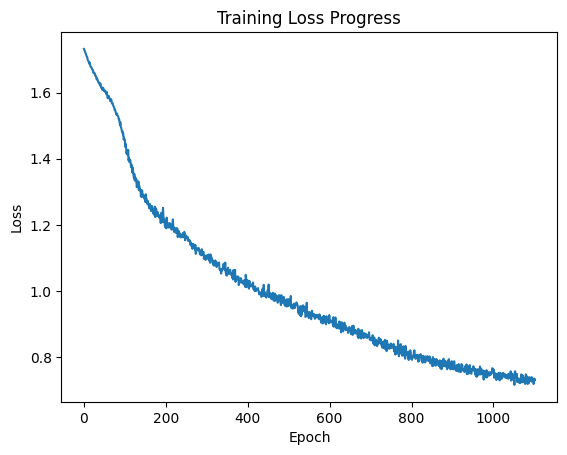

In [11]:
plt.plot(losses_model2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()

### 3.4. Model 3: HAN-GAE (Multi-modal)
This is the most advanced model. It incorporates public transit (Bus) edges into the accessibility layer. OAs are connected if reachable within 15 minutes by walking AND bus.

In [12]:
set_seeds(config['seeds']['model']) # Ensure deterministic model training initialization
print("\nRunning Model 3: HAN-GAE (Multi-modal)...")
multi_path = os.path.join("../", config['data']['root'], config['data']['hetero_multi'])

multi_data = torch.load(multi_path, map_location=device, weights_only=False)

# Metapaths for Model 3
#metapaths_multi = ['contig', '15_min_walk', '15_min_multi']
metapaths_multi = ['contig','15_min_multi']

han_multi = HANGAE(
    in_dim=config['model']['in_dim'],
    hidden_dim=config['model']['hidden_dim'],
    out_dim=config['model']['out_dim'],
    metapaths=metapaths_multi,
    heads=config['model']['heads'],
    dropout=config['model']['dropout'],
    edge_dim_dict={'contig': 1, '15_min_multi': 1}

).to(device)

data_model3, losses_model3 = train_model(han_multi, multi_data, config, "model3_han_gae_multi")

Random seed set to: 42

Running Model 3: HAN-GAE (Multi-modal)...
Training model3_han_gae_multi...
Epoch 0, Total Loss: 1.7324, Feat Loss: 0.3450, Struct Loss: 1.3874
Epoch 10, Total Loss: 1.7043, Feat Loss: 0.3379, Struct Loss: 1.3664
Epoch 20, Total Loss: 1.6723, Feat Loss: 0.3321, Struct Loss: 1.3401
Epoch 30, Total Loss: 1.6386, Feat Loss: 0.3260, Struct Loss: 1.3126
Epoch 40, Total Loss: 1.6071, Feat Loss: 0.3209, Struct Loss: 1.2861
Epoch 50, Total Loss: 1.6061, Feat Loss: 0.3195, Struct Loss: 1.2865
Epoch 60, Total Loss: 1.5707, Feat Loss: 0.3186, Struct Loss: 1.2520
Epoch 70, Total Loss: 1.5547, Feat Loss: 0.3180, Struct Loss: 1.2368
Epoch 80, Total Loss: 1.5389, Feat Loss: 0.3182, Struct Loss: 1.2206
Epoch 90, Total Loss: 1.5050, Feat Loss: 0.3182, Struct Loss: 1.1867
Epoch 100, Total Loss: 1.4848, Feat Loss: 0.3186, Struct Loss: 1.1662
Epoch 110, Total Loss: 1.4636, Feat Loss: 0.3172, Struct Loss: 1.1464
Epoch 120, Total Loss: 1.4537, Feat Loss: 0.3175, Struct Loss: 1.1362
Ep

In [13]:
data_model3

HeteroData(
  crs=EPSG:27700,
  graph_metadata=<city2graph.base.GraphMetadata object at 0x1369b5810>,
  oa={
    x=[1624, 23],
    pos=[1624, 2],
    embedding_0=[1624],
    embedding_1=[1624],
    embedding_2=[1624],
    embedding_3=[1624],
    embedding_4=[1624],
    embedding_5=[1624],
    embedding_6=[1624],
    embedding_7=[1624],
    embedding_8=[1624],
    embedding_9=[1624],
    embedding_10=[1624],
    embedding_11=[1624],
    embedding_12=[1624],
    embedding_13=[1624],
    embedding_14=[1624],
    embedding_15=[1624],
    beta1_0=[1624],
    beta1_1=[1624],
    beta2_0=[1624],
    beta2_1=[1624],
  },
  street_connector={
    x=[49699, 0],
    pos=[49699, 2],
  },
  bus_station={
    x=[1724, 0],
    pos=[1724, 2],
  },
  (oa, contig, oa)={
    edge_index=[2, 4782],
    edge_attr=[4782, 1],
  },
  (street_connector, is_connected_to, street_connector)={
    edge_index=[2, 65386],
    edge_attr=[65386, 1],
  },
  (bus_station, connects, oa)={
    edge_index=[2, 0],
    edge_a

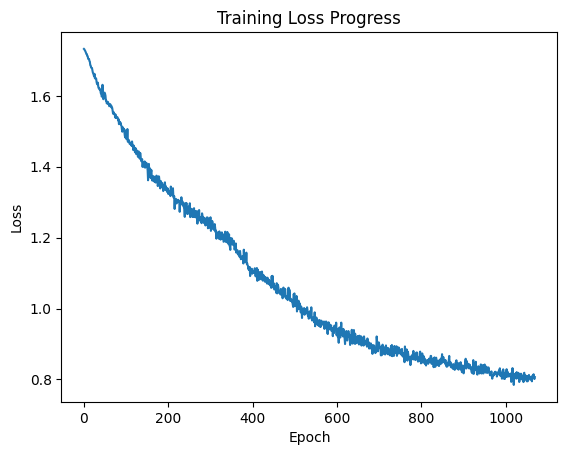

In [14]:
plt.plot(losses_model3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()

### 3.5. Model 4: HAN-GAE (All Relations)
This model combines all available signals: Contiguity, 15-min Street accessibility, and 15-min Multi-modal (Walking OR Bus) accessibility.

In [15]:
set_seeds(config['seeds']['model']) # Ensure deterministic model training initialization
print("\nRunning Model 4: HAN-GAE (All Relations)...")
multi_path = os.path.join("../", config['data']['root'], config['data']['hetero_multi'])

multi_data = torch.load(multi_path, map_location=device, weights_only=False) 

# Metapaths for Model 4
metapaths_model4 = ['contig', '15_min_walk', '15_min_multi']

han_model4 = HANGAE(
    in_dim=config['model']['in_dim'],
    hidden_dim=config['model']['hidden_dim'],
    out_dim=config['model']['out_dim'],
    metapaths=metapaths_model4,
    heads=config['model']['heads'],
    dropout=config['model']['dropout'],
    edge_dim_dict={'contig': 1, '15_min_walk': 1, '15_min_multi': 1}
).to(device)

data_model4, losses_model4 = train_model(han_model4, multi_data, config, "model4_han_gae_all")

Random seed set to: 42

Running Model 4: HAN-GAE (All Relations)...
Training model4_han_gae_all...
Epoch 0, Total Loss: 1.7369, Feat Loss: 0.3512, Struct Loss: 1.3857
Epoch 10, Total Loss: 1.7156, Feat Loss: 0.3407, Struct Loss: 1.3749
Epoch 20, Total Loss: 1.6797, Feat Loss: 0.3314, Struct Loss: 1.3484
Epoch 30, Total Loss: 1.6499, Feat Loss: 0.3272, Struct Loss: 1.3227
Epoch 40, Total Loss: 1.6045, Feat Loss: 0.3230, Struct Loss: 1.2815
Epoch 50, Total Loss: 1.5809, Feat Loss: 0.3239, Struct Loss: 1.2571
Epoch 60, Total Loss: 1.5427, Feat Loss: 0.3200, Struct Loss: 1.2226
Epoch 70, Total Loss: 1.5307, Feat Loss: 0.3195, Struct Loss: 1.2112
Epoch 80, Total Loss: 1.5103, Feat Loss: 0.3188, Struct Loss: 1.1915
Epoch 90, Total Loss: 1.4890, Feat Loss: 0.3172, Struct Loss: 1.1718
Epoch 100, Total Loss: 1.4750, Feat Loss: 0.3166, Struct Loss: 1.1585
Epoch 110, Total Loss: 1.4515, Feat Loss: 0.3159, Struct Loss: 1.1356
Epoch 120, Total Loss: 1.4281, Feat Loss: 0.3164, Struct Loss: 1.1118
Ep

In [16]:
data_model4

HeteroData(
  crs=EPSG:27700,
  graph_metadata=<city2graph.base.GraphMetadata object at 0x142a38e90>,
  oa={
    x=[1624, 23],
    pos=[1624, 2],
    embedding_0=[1624],
    embedding_1=[1624],
    embedding_2=[1624],
    embedding_3=[1624],
    embedding_4=[1624],
    embedding_5=[1624],
    embedding_6=[1624],
    embedding_7=[1624],
    embedding_8=[1624],
    embedding_9=[1624],
    embedding_10=[1624],
    embedding_11=[1624],
    embedding_12=[1624],
    embedding_13=[1624],
    embedding_14=[1624],
    embedding_15=[1624],
    beta1_0=[1624],
    beta1_1=[1624],
    beta1_2=[1624],
    beta2_0=[1624],
    beta2_1=[1624],
    beta2_2=[1624],
  },
  street_connector={
    x=[49699, 0],
    pos=[49699, 2],
  },
  bus_station={
    x=[1724, 0],
    pos=[1724, 2],
  },
  (oa, contig, oa)={
    edge_index=[2, 4782],
    edge_attr=[4782, 1],
  },
  (street_connector, is_connected_to, street_connector)={
    edge_index=[2, 65386],
    edge_attr=[65386, 1],
  },
  (bus_station, connects,

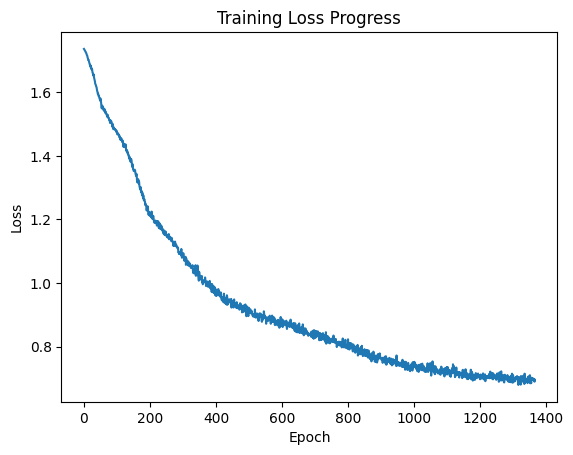

In [17]:
plt.plot(losses_model4)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()